In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import networkx as nx
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import requests
import tempfile
import logging
from io import StringIO

In [ ]:
#df = pd.read_csv("data/04022021.csv")
#df = pd.read_csv("data/05022021.csv")
#df = pd.read_csv("data/job_results_second_run.csv")
#df = pd.read_csv("data/job_results.csv")
#df = pd.read_csv("data/15022021.csv")

#df = pd.read_csv("data/pcalg-vs-bnlearn-continuous.csv")
df = pd.read_csv("data/bnlearn_test_2.csv")
#df = pd.read_csv("data/discrete.csv")
#df.columns

In [ ]:
df.columns

In [120]:
dataset_config = [c for c in df.columns if c.startswith("config")]
gd_compare = [c for c in df.columns if c.startswith("gd_compare") and not c.endswith("edges")]
result = ['result/dataset_loading_time', 'result/execution_time', 'result/meta_results/sampling_factor']
experiment_config = ["experiment_config/parameters/alpha", "experiment_config/algorithm/function", "experiment_config/algorithm/package", "experiment_config/name"]


In [121]:
# Selecting relevant columns
columns = dataset_config + gd_compare + experiment_config + result

In [122]:
#Renaming columns
renaming_dict = {}
for c in columns:
    name_split = c.split("/")
    name = name_split[-1]
    
    if name == "rate":
        name = name_split[-2]
        
    renaming_dict[c] = name

cleaned_df = df[columns].rename(columns=renaming_dict)

In [123]:
continous_data = cleaned_df[cleaned_df.discrete_node_ratio == 0]
mix_data = cleaned_df[cleaned_df.discrete_node_ratio > 0][cleaned_df.discrete_node_ratio < 1]
discrete_data = cleaned_df[cleaned_df.discrete_node_ratio == 1]

<ipython-input-123-4a95f828dd7a>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mix_data = cleaned_df[cleaned_df.discrete_node_ratio > 0][cleaned_df.discrete_node_ratio < 1]


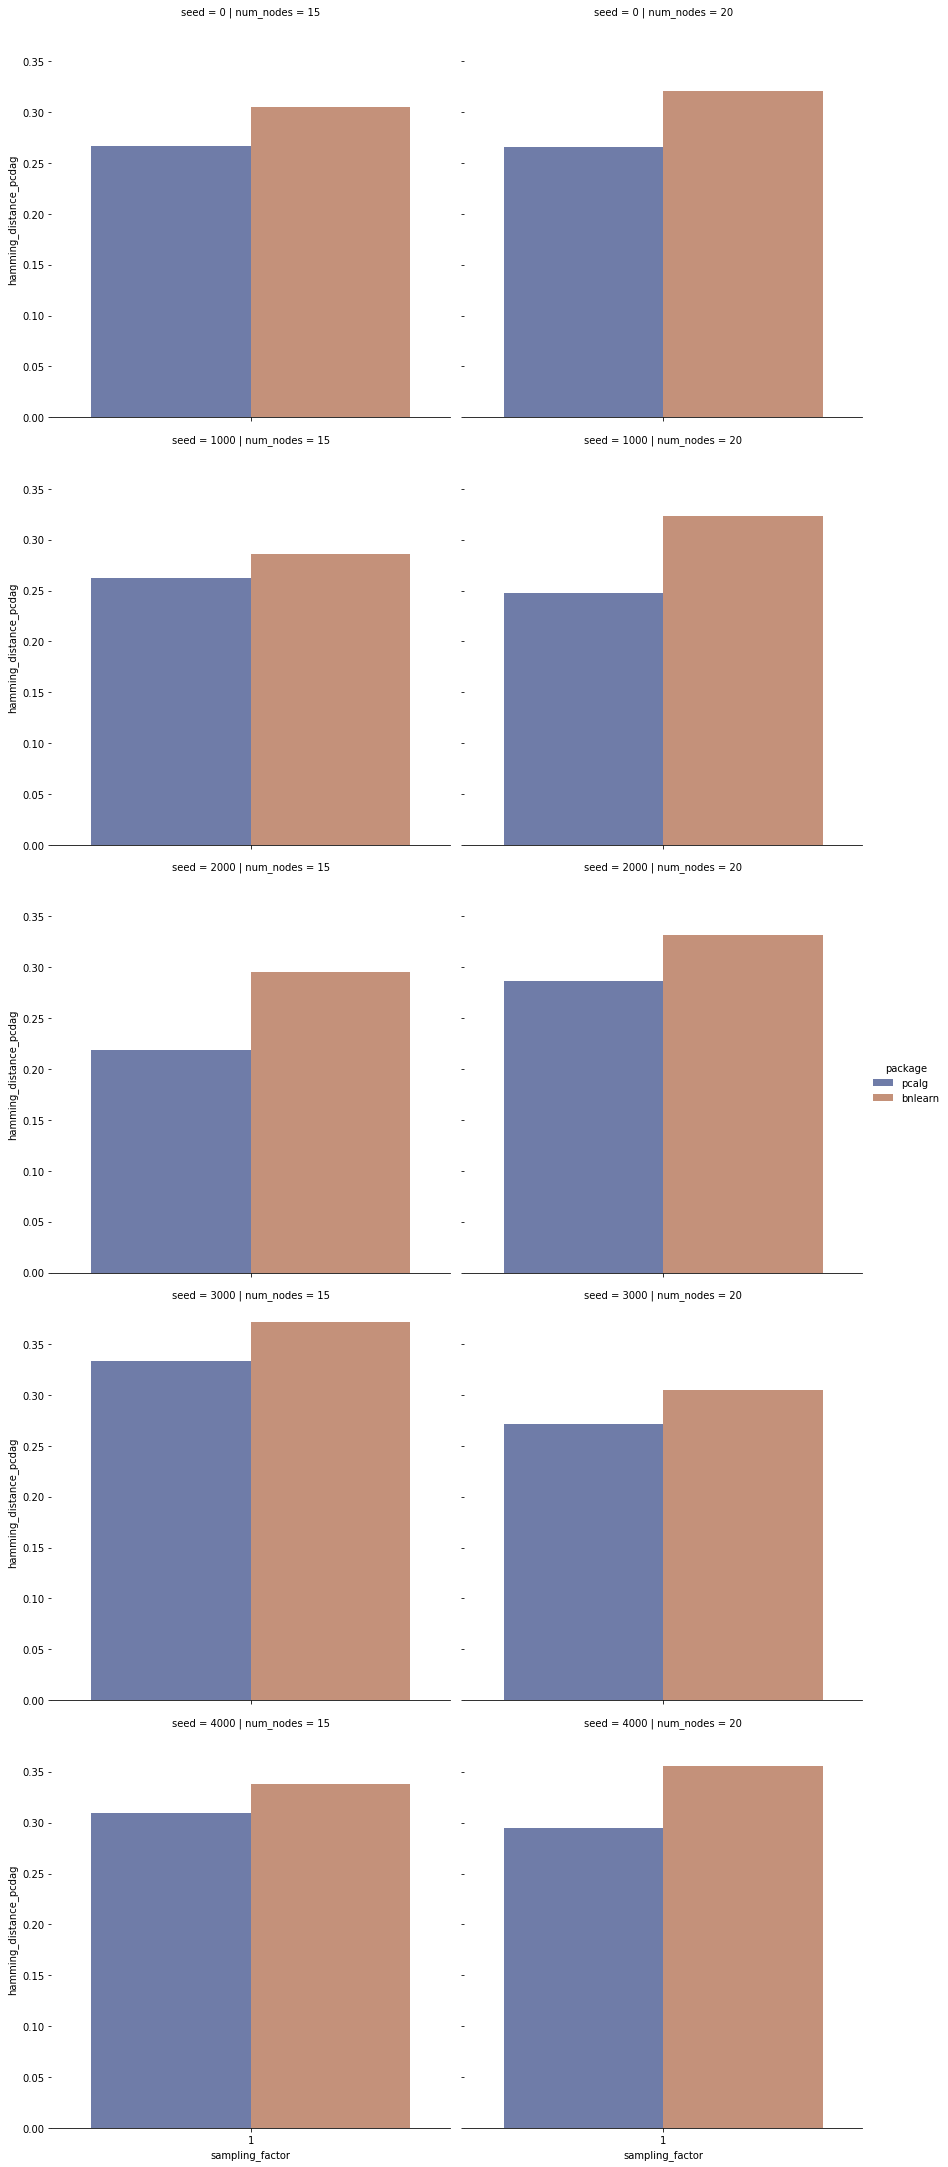

In [124]:
["num_nodes", "edge_density", "num_samples", "alpha", "discrete_node_ratio"]
metrics = ["hamming_distance_pcdag"] #"graph_edit_distance", "mean_jaccard_coefficient"]
plotted_data = cleaned_df

for metric in metrics:
    
    x="sampling_factor"
    y=metric
    #hue="sampling_factor"
    hue="package"
    #hue="generator"
    row="seed"
    col="num_nodes"
    
    g = sns.catplot(
        data=plotted_data,
        kind="bar",
        x=x,
        y=metric,
        hue=hue,
        row=row,
        col=col,
        palette="dark",
        alpha=.6,
        height=6,
        facet_kws=dict(margin_titles=True),
    )
    #plt.title(f'Metric: {metric}, x={x}, y={y}, hue={hue}, row={row}, col={col}')
    display(g.despine(left=True))
    g.savefig("output.png")

In [125]:
plotted_data[["hamming_distance", "hamming_distance_pcdag"]][plotted_data.hamming_distance != plotted_data.hamming_distance_pcdag]

,hamming_distance,hamming_distance_pcdag
0,0.261905,0.266667
1,0.300000,0.304762
2,0.252381,0.261905
4,0.214286,0.219048
5,0.290476,0.295238
8,0.280952,0.309524
9,0.319048,0.338095
10,0.263158,0.265789
11,0.318421,0.321053
12,0.244737,0.247368


In [126]:
edge_density = 0.6
num_nodes = 5
discrete_node_ratio = 0.4

filtered_df = df[
    (df["config/edge_density"] == edge_density) &
    (df["config/num_nodes"] == num_nodes) &
    (df["config/discrete_node_ratio"] == discrete_node_ratio)
]
display(filtered_df.head()[["experiment_config/dataset"]])
network_data = df[["result/job_id",  "result/id", "experiment_config/dataset", "result/meta_results/sampling_factor", "gd_compare/hamming_distance", "config/edge_density", "config/discrete_node_ratio", "config/num_nodes"]]

,experiment_config/dataset


In [127]:
retry_strategy = Retry(
    total=3,
    status_forcelist=[429, 500, 502, 503, 504],
    method_whitelist=["GET", "PUT", "DELETE", "OPTIONS"],
    backoff_factor=10
)
adapter = HTTPAdapter(max_retries=retry_strategy)
http = requests.Session()
http.mount("http://", adapter)

In [128]:
API_HOST = "http://galileo.eaalab.hpi.uni-potsdam.de:5000"
#API_HOST = "http://localhost:5000"
API_RESULT_GRAPH = lambda result_id : f"{API_HOST}/api/result/{result_id}/export?format=GML"
API_GROUND_TRUTH_GRAPH = lambda dataset_id : f"{API_HOST}/api/dataset/{dataset_id}/ground-truth?format=GML"

def get_est_graph(result_id: int, tmp_path="./est_graph.gml"):
    response_graph = http.get(API_RESULT_GRAPH(result_id))

    if response_graph.status_code != 200:
        error_msg = f"API Request to {API_RESULT_GRAPH(result_id)} failed."
        raise Exception(error_msg)

    with open(tmp_path, 'wb') as f:
        f.write(response_graph.content)
        
    return nx.read_gml(tmp_path)

def get_gt_graph(dataset_id: int, tmp_path="./gt-download.gml"):
    response_graph = http.get(API_GROUND_TRUTH_GRAPH(dataset_id))

    if response_graph.status_code != 200:
        error_msg = f"API Request to {API_GROUND_TRUTH_GRAPH(dataset_id)} failed."
        logging.error(error_msg)
        raise Exception(error_msg)
        
    with open(tmp_path, 'wb') as f:
        f.write(response_graph.content)

    return nx.read_gml(tmp_path)

interactive(children=(Dropdown(description='edge_density', options=(0.6,), value=0.6), Dropdown(description='n…

<function __main__.f(edge_density: float, num_nodes: int, discrete_node_ratio: float, sampling_factor: int)>

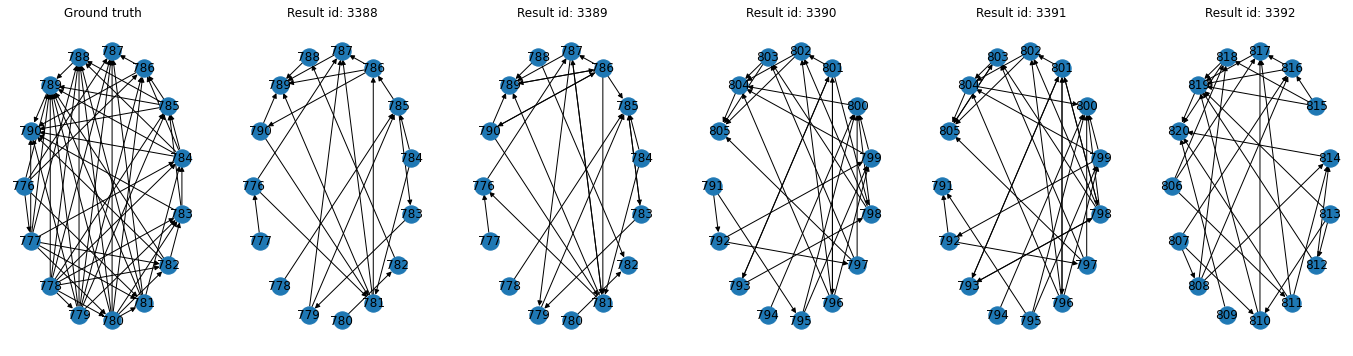

In [129]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def f(edge_density: float,
      num_nodes: int,
      discrete_node_ratio: float,
      sampling_factor: int):
    
    filtered_df = df[
        (df["config/edge_density"] == edge_density) &
        (df["config/num_nodes"] == num_nodes) &
        (df["config/discrete_node_ratio"] == discrete_node_ratio) &
        (df["result/meta_results/sampling_factor"] == sampling_factor)
    ]
    filtered_df = filtered_df[["result/job_id",  "result/id", "experiment_config/dataset", "result/meta_results/sampling_factor", "gd_compare/hamming_distance", "config/edge_density", "config/discrete_node_ratio", "config/num_nodes"]]
    display(filtered_df)

    dataset_id = filtered_df.iat[0, 2]

    gt_graph = get_gt_graph(dataset_id)
    
    plot_index = 161
    plt.figure(figsize=(24, 6))
    plt.subplot(plot_index)
    nx.draw_shell(gt_graph, with_labels = True)
    plt.title("Ground truth")
    #plt.show()
    
    current_plot_index = plot_index 
    #display(nx.draw_spring(gt_graph, with_labels = True))
    for i, row in filtered_df.iterrows():
        current_plot_index += 1
        result_id = int(row["result/id"])
        est_graph = get_est_graph(result_id)
        
        #print(current_plot_index)
        plt.subplot(current_plot_index)
        nx.draw_shell(est_graph, with_labels = True)
        plt.title(f"Result id: {result_id}")

    plt.show()
    #plt.figsize(15,15)
    
interact(f,
    edge_density=network_data["config/edge_density"].unique(),
    sampling_factor=network_data["result/meta_results/sampling_factor"].unique(),
    num_nodes=network_data["config/num_nodes"].unique(),
    discrete_node_ratio=network_data["config/discrete_node_ratio"].unique(),
)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
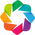

Loading BokehJS ...

In [130]:
from bokeh.io import output_notebook, reset_output, show, output_file
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler

from scipy.stats import norm
import seaborn as sns
from scipy.stats import pearsonr

from bokeh.models import (BoxZoomTool, Circle, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool,)
from bokeh.palettes import Spectral11
from bokeh.plotting import from_networkx

from bokeh.layouts import gridplot
from bokeh.plotting import figure

from src.manm_cs.graph import Graph, GraphBuilder
from scipy.stats import norm
import holoviews as hv
from holoviews import opts
reset_output()
hv.extension('bokeh')
output_notebook()

In [131]:
API_DATASET_DOWNLOAD = lambda dataset_id : f'{API_HOST}/api/dataset/{dataset_id}/loadwithids'

def get_dataset(dataset_id: int):
    response_dataset = http.get(API_DATASET_DOWNLOAD(dataset_id))

    if response_dataset.status_code != 200:
        error_msg = f"API Request to {API_DATASET_DOWNLOAD(dataset_id)} failed."
        raise Exception(error_msg)
        
    return pd.read_csv(StringIO(response_dataset.text))

def is_discrete(df: pd.DataFrame, column: int):
    return df.dtypes[column] == "int64"

def create_pair_plot(df, ground_truth):

    # create three plots
    plots = []
    nodes = df.columns
    node_max = nodes[-1]
    node_min = nodes[0]

    for row_index, row in enumerate(nodes):
        for column_index, column in enumerate(nodes):

            if column_index > row_index:
                plots.append(None)
                continue

            x_axis_label = f"Node {column}" if row_index == len(nodes) - 1 else ""
            y_axis_label = f"Node {row}" if column_index == 0 else ""

            # create figure with data
            s1 = figure(x_axis_label=x_axis_label, y_axis_label=y_axis_label)

            # Check whether edge is present in groun truth
            is_edge = (row, column) in ground_truth.edges or (column, row) in ground_truth.edges

            s1.background_fill_color = "green" if is_edge else "red"
            s1.background_fill_alpha = 0.05

            x = df[column]
            y = df[row]

            if is_discrete(df, column):
                if column != row:
                    if is_discrete(df, row):
                        data = pd.DataFrame(pd.crosstab(x, y).to_numpy()).reset_index().melt('index')
                        data.columns = [f"Node {column}", f"Node {row}", "value"]
                        data.value = data.value / np.sum(data.value)
                        hm = hv.HeatMap(data)
                        hm.opts(
                            xticks=None,
                            xlabel=x_axis_label,
                            ylabel=y_axis_label,
                            cmap='Greens' if is_edge else "Reds"
                        )
                        #hm = hm * hv.Labels(hm)
                        s1 = hv.render(hm)
                    else:
                        for discrete_value in x.unique():
                            mask = x == discrete_value

                            sample_mean = np.mean(y[mask])
                            sample_std = np.std(y[mask])
                            dist = norm(sample_mean, sample_std)

                            sorted_values = sorted(y[mask])
                            probabilities = [dist.pdf(value) for value in sorted_values]

                            s1.line(sorted_values, probabilities, line_color=Spectral11[discrete_value], line_width=1, alpha=0.7, legend_label=f"{discrete_value}")
                            s1.legend.background_fill_alpha = 0.5
                else:
                    s1.background_fill_color = "white"

                    counts = x.value_counts()
                    s1.vbar(x=x.unique(), top=counts, width=0.9, fill_color="navy", line_color="white", alpha=0.5)

                    #s1.xgrid.grid_line_color = None
                    #s1.y_range.start = 0
            else:
                if column != row:
                    # Create scatter plot
                    s1.circle(x, y, size=1, alpha=0.8, color="#53777a")

                    # calculate slope + intercept
                    par = np.polyfit(x, y, 1, full=True)
                    slope=par[0][0]
                    intercept=par[0][1]
                    y_predicted = [slope*i + intercept  for i in x]
                    s1.line(x,y_predicted,color='red',legend_label=f"Corr: {round(pearsonr(x=x, y=y)[0], 4)}")
                    s1.legend.background_fill_alpha = 0.5
                else:
                    #diag plot --> histogram
                    s1.background_fill_color = "white"

                    node = row 
                    hist, edges = np.histogram(df[node], density=True, bins=50)

                    s1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
                           fill_color="navy", line_color="white", alpha=0.5)

            plots.append(s1)

    # make a grid
    grid = gridplot(plots, ncols=len(df.columns), plot_width=250, plot_height=250)

    return grid

In [132]:
dataset_id = 22

#df = get_dataset(dataset_id)
#ground_truth = get_gt_graph(dataset_id)

In [133]:
#grid = create_pair_plot(df, ground_truth)

#show(grid)

In [134]:
edges = [
    "gd_compare/error_types/false_positives/edges",
    "gd_compare/error_types/false_negatives/edges",
    "gd_compare/error_types/true_negatives/edges",
    'gd_compare/error_types/true_positives/edges'
]

algorithm = [
    "experiment_config/algorithm/package",
    "result/id", 
    "result/meta_results/sampling_factor",
    "gd_compare/hamming_distance",
    "config/edge_density",
    "config/num_nodes",
    "config/seed"
]

edge_df = df[algorithm].dropna()

In [135]:
#sampling_factor num_nodes edge_density result_id_pcalg result_id_bnlearn

sampling_factors = edge_df["result/meta_results/sampling_factor"].unique()
num_nodes = edge_df["config/num_nodes"].unique()
edge_densities = edge_df["config/edge_density"].unique()
seeds = edge_df["config/seed"].unique()
#packages = edge_df["experiment_config/algorithm/package"].unique()

In [136]:
gml_map = {}
for index, row in edge_df.iterrows():
            
    result_id = row["result/id"]
    if result_id:
        result_id = int(result_id)
        gml_map[result_id] = get_est_graph(result_id)

In [137]:
import netrd

pcalg_results = test[test["experiment_config/algorithm/package"] == "pcalg" ]
bnlearn = test[test["experiment_config/algorithm/package"] == "bnlearn" ]
distance_calculator = netrd.distance.Hamming()

distances = []

for sampling_factor in sampling_factors:
    for num_node in num_nodes:
        for edge_density in edge_densities:
            for seed in seeds:
                try:
                    pcalg_graph = edge_df[
                        (edge_df["config/num_nodes"] == num_node) &
                        (edge_df["config/edge_density"] == edge_density) &
                        (edge_df["result/meta_results/sampling_factor"] == sampling_factor) &
                        (edge_df["config/seed"] == seed) &
                        (edge_df["experiment_config/algorithm/package"] == "pcalg")
                    ]

                    pcalg_result_id = int(pcalg_graph["result/id"].iloc[0])
                    pcalg_graph = gml_map[pcalg_result_id]
                    undirected_pcalg_graph = pcalg_graph.to_undirected()

                    bnlearn_graph = edge_df[
                        (edge_df["config/num_nodes"] == num_node) &
                        (edge_df["config/edge_density"] == edge_density) &
                        (edge_df["result/meta_results/sampling_factor"] == sampling_factor) &
                        (edge_df["config/seed"] == seed) &
                        (edge_df["experiment_config/algorithm/package"] == "bnlearn")
                    ]
                    #display(bnlearn_graph)
                    bnlearn_result_id = int(bnlearn_graph["result/id"].iloc[0]) 
                    bnlearn_graph = gml_map[bnlearn_result_id]
                    undirected_bnlearn_graph = bnlearn_graph.to_undirected()
                    
                    shd = distance_calculator.dist(undirected_pcalg_graph, undirected_bnlearn_graph)
                    distances.append(shd)
                    print(f"pcalg edges {len(undirected_pcalg_graph.edges)} bnlearn edges {len(undirected_bnlearn_graph.edges)} shd {shd}")
                except: 
                    print("error")


pcalg edges 23 bnlearn edges 23 shd 0.0
pcalg edges 29 bnlearn edges 29 shd 0.0
pcalg edges 30 bnlearn edges 30 shd 0.0
pcalg edges 27 bnlearn edges 27 shd 0.0
pcalg edges 27 bnlearn edges 27 shd 0.0
pcalg edges 44 bnlearn edges 44 shd 0.0
pcalg edges 37 bnlearn edges 37 shd 0.0
pcalg edges 39 bnlearn edges 39 shd 0.0
pcalg edges 38 bnlearn edges 38 shd 0.0
pcalg edges 46 bnlearn edges 46 shd 0.0


/Users/lukas/anaconda3/envs/mpci-backend/lib/python3.8/site-packages/netrd/utilities/graph.py:118: RuntimeWarning: Coercing weighted graph to unweighted.
  warnings.warn("Coercing weighted graph to unweighted.", RuntimeWarning)
/Users/lukas/anaconda3/envs/mpci-backend/lib/python3.8/site-packages/netrd/utilities/graph.py:118: RuntimeWarning: Coercing weighted graph to unweighted.
  warnings.warn("Coercing weighted graph to unweighted.", RuntimeWarning)
/Users/lukas/anaconda3/envs/mpci-backend/lib/python3.8/site-packages/netrd/utilities/graph.py:118: RuntimeWarning: Coercing weighted graph to unweighted.
  warnings.warn("Coercing weighted graph to unweighted.", RuntimeWarning)
/Users/lukas/anaconda3/envs/mpci-backend/lib/python3.8/site-packages/netrd/utilities/graph.py:118: RuntimeWarning: Coercing weighted graph to unweighted.
  warnings.warn("Coercing weighted graph to unweighted.", RuntimeWarning)
/Users/lukas/anaconda3/envs/mpci-backend/lib/python3.8/site-packages/netrd/utilities/gra

In [138]:
distances

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [4]:
performance_analysis = pd.read_csv("data/performance_analysis.csv")

performance_analysis.head()

,Unnamed: 0,num_nodes,edge_density,discrete_node_ratio,discrete_signal_to_noise_ratio,min_discrete_value_classes,max_discrete_value_classes,continuous_noise_std,continuous_beta_mean,continuous_beta_std,num_samples,num_processes,keep_data,time_generation,time_csv,time_gt,path_dataset,path_ground_truth,success
0,0,10,0.5,0.5,0.95,3,4,1.0,0.0,0.5,10000,16,False,505.749,622.734,623.743,../datasets/20fe04e64ce15f981ad7db782d704f82ed...,20fe04e64ce15f981ad7db782d704f82edfaa2591ac063...,True
1,1,10,0.5,0.5,0.95,3,4,1.0,0.0,0.5,10000,32,False,336.308,466.179,466.532,../datasets/ad5cb62fc148eb5538bc6903d68ed15908...,ad5cb62fc148eb5538bc6903d68ed159080fdd8328cbf1...,True
2,2,10,0.5,0.5,0.95,3,4,1.0,0.0,0.5,10000,64,False,381.492,525.574,525.901,../datasets/a43df137e286b3311744c5146d68caf7f9...,a43df137e286b3311744c5146d68caf7f9c4a5c7d4236c...,True
3,3,10,0.5,0.5,0.95,3,4,1.0,0.0,0.5,100000,16,False,1546.895,2493.317,2493.913,../datasets/ceba9f6b00118c8b399617fa7834ee0cf1...,ceba9f6b00118c8b399617fa7834ee0cf13b5dda647e50...,True
4,4,10,0.5,0.5,0.95,3,4,1.0,0.0,0.5,100000,32,False,1206.678,2178.306,2178.975,../datasets/d7d3ee600ab2bc5818699c0a209e2ebc96...,d7d3ee600ab2bc5818699c0a209e2ebc9600bf14733044...,True


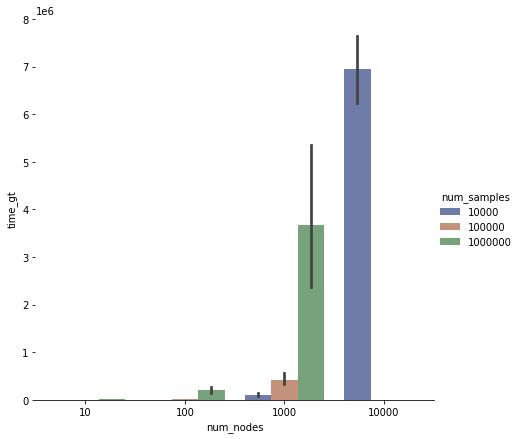

In [7]:
g = sns.catplot(
        data=performance_analysis,
        kind="bar",
        x="num_nodes",
        y="time_gt",
        hue="num_samples",
        palette="dark",
        alpha=.6,
        height=6,
        facet_kws=dict(margin_titles=True),
    )
#plt.title(f'Metric: {metric}, x={x}, y={y}, hue={hue}, row={row}, col={col}')
display(g.despine(left=True))